# Neighbor-Joining Algorithm

Below is a similarity matrix determined by the likelihood of transition vs transversion mutations. Over the entire genome, a base that is related by a transition to another base is twice as likely to be mutated to that base than a base it is related to by transversion. For example, A and G are related by transition, since they are both purines. A transition mutation from A to G or vice-versa would then be twice as likely as a transversion mutation. Thus, in a similarity matrix, we could define an A to G mutation or a G to A transition as half as dissimilar as any transversion mutation. We could also define the lack of mutation, in which a base stays the same, as a score of 0. Scores in this similarity matrix range from identical at 0 to very dissimilar at 2.

In [1]:
from math import log, exp

DNA_sim = {'G': { 'A': 1, 'G': 0, 'C': 2, 'T': 2 },
         'C': { 'A': 1, 'G': 2, 'C': 0, 'T': 1 },
         'T': { 'A': 2, 'G': 2, 'C': 1, 'T': 0 },
         'A': { 'A': 0, 'G': 1, 'C': 2, 'T': 2 }}

seq = ['CAGCCGCACACAGATCCTGAG',
       'CAGCTGCACGCAGATCCTGAG',
       'CGGCTGCACGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGGCTGCACGTGGATCCTGAG',
       'CGGCTGCACGTGGATCCTGAG',
       'CAGCTGCATGTGGACCCTGAG', 
       'CAGCTGCATGTGGACCCAGAG', 
       'CGGCTGCATGTGGACCCAGAT']

This function calculates the similarity between two sequences given the penalties listed in the similarity matrix sim_mat.

In [2]:
def seq_sim(s1, s2, sim_mat):

  num_bases = min(len(s1), len(s2))
  
  seq_score = 0.0
  
  for i in range(num_bases):
    
    bases1 = s1[i]
    bases2 = s2[i]
  
    seq_score += sim_mat[bases1][bases2]

  return seq_score

This function aligns any two sequences.

In [3]:
def seq_align(s1, s2, sim_mat=DNA_sim, insert=8, extend=4):

  num_s1 = len(s1) + 1
  num_s2 = len(s2) + 1

  score_mat = [[0] * num_s2 for x in range(num_s1)]
  rt_mat = [[0] * num_s2 for x in range(num_s1)]
  
  for i in range(1, num_s1):
    rt_mat[i][0] = 1
  
  for j in range(1, num_s2):
    rt_mat[0][j] = 2
  
  for i in range(1, num_s1):
    for j in range(1, num_s2):
    
      penalty1 = insert
      penalty2 = insert
      
      if rt_mat[i-1][j] == 1:
        penalty1 = extend
        
      elif rt_mat[i][j-1] == 2:
        penalty2 = extend
        
      sim = sim_mat[ s1[i-1] ][ s2[j-1] ]
      
      paths = [score_mat[i-1][j-1] + sim, # rt 0
               score_mat[i-1][j] - penalty1, # rt 1
               score_mat[i][j-1] - penalty2] # rt 2                     
      
      best = max(paths)
      rt = paths.index(best)           

      score_mat[i][j] = best
      rt_mat[i][j] = rt
      
  align_s1 = []
  align_s2 = []
  
  i = num_s1-1
  j = num_s2-1
  score = score_mat[i][j]

    
  while i > 0 or j > 0:
    rt = rt_mat[i][j]    

    if rt == 0: # Diagonal
      align_s1.append( s1[i-1] )
      align_s2.append( s2[j-1] )
      i -= 1
      j -= 1
        
    elif rt == 1: # Gap in s2
      align_s1.append( s1[i-1] )
      align_s2.append( '-' )
      i -= 1      

    elif rt == 2: # Gap in s1
      align_s1.append( '-' )
      align_s2.append( s2[j-1] ) 
      j -= 1
  
  align_s1.reverse()
  align_s2.reverse()
  align_s1 = ''.join(align_s1)
  align_s2 = ''.join(align_s2)

  return score, align_s1, align_s2 


This function calculates a substitution matrix given a dataset of sequences and their respective alignments.

In [4]:
def sub_matrix(alignments, alphabet, maxVal, smooth=5):

  matrix = {}
  counts = {}
  
  for letterA in alphabet:
    subDict = {}
    
    for letterB in alphabet:
      subDict[letterB] = 0
  
    matrix[letterA] = subDict
    counts[letterA] = 0
  
  totalRes = 0.0
  totalSub = 0.0

  for align in alignments:
 
    numPos = len(align[0])

    for i in range(numPos):
 
      letters = []
      
      for seq in align:

        letter = seq[i]
        if letter == '-':
          continue
    
        letters.append(letter)

      for letterA in letters:
        counts[letterA] += 1
      
        for letterB in letters:          
          matrix[letterA][letterB] += 1

      numLetters = len(letters)
      totalRes += numLetters    
      totalSub += numLetters * numLetters

  avg_comp = {}    
  for letter in alphabet:
    avg_comp[letter] = counts[letter]/totalRes      

  maxScore = None
  for resA in alphabet:
    for resB in alphabet:

      expected = avg_comp[resA] * avg_comp[resB]
      
      if not expected:
        continue

      obs = matrix[resA][resB]
      weight = 1.0 / (1.0+(obs/smooth))

      obs /= totalSub
      obs = weight*expected + (1-weight)*obs

      logOdds = log(obs/expected)
                  
      if (maxScore is None) or (logOdds>maxScore):
        maxScore = logOdds
      
      matrix[resA][resB] = logOdds

  maxScore = abs(maxScore)

  for resA in alphabet:
    for resB in alphabet:
      matrix[resA][resB] = int(maxVal*matrix[resA][resB]/maxScore)

  return matrix

This function calculates the distance matrix for given sequence data.

In [5]:
def calc_dist_mat(seq_data, sim_mat):

  n = len(seq_data)
  matrix = [[0.0] * n for i in range(n)]
  maxScores = [seq_sim(i, i, sim_mat) for i in seq_data]

  for i in range(n-1):
    s1 = seq_data[i]
  
    for j in range(i+1,n):
      s2 = seq_data[j]
      
      score, align_s1, align_s2 = seq_align(s1, s2, sim_mat)
      maxScore = max(maxScores[i],maxScores[j])
      dist = maxScore - score
      
      matrix[i][j] = dist
      matrix[j][i] = dist

  return matrix

This function uses the distance matrix to determine which pairs of sequences should be joined.

In [6]:
def joinPair(dist_mat):

  n = len(dist_mat)

  minQ = None
  joinPair = None

  for i in range(n-1):
    sumRow = sum(dist_mat[i])
  
    for j in range(i+1, n):
      sumCol = sum(dist_mat[j])
    
      dist = dist_mat[i][j]
      q = (n-2)*dist - sumRow - sumCol
      
      if (minQ is None) or (q < minQ):
        minQ = q
        joinPair = [i,j]

  return joinPair

This function determines the distance of each sequence to the node formed by the first two sequences paired.

In [7]:
def distToNode(dist_mat, i, j):
  
  n = len(dist_mat)
  row = dist_mat[i]
  column = dist_mat[j]
 
  dist = dist_mat[i][j] + (sum(row)-sum(column))/(n-2)
  dist *= 0.5

  return dist

This function enacts the neighbor-joining algorithm given the distance matrix of a dataset of sequences.

In [8]:
def njTree(dist_mat):
 
  joinOrder = []
  n = len(dist_mat)
  tree = list(range(n))  # do not need list() in Python 2
  
  while n > 2:

    x, y = joinPair(dist_mat)

    node = (tree[x], tree[y])
    joinOrder.append(node)
    tree.append(node)

    del tree[y]
    del tree[x]

    distX = distToNode(dist_mat, x, y)
    distY = distToNode(dist_mat, y, x)
  
    dist_mat.append([0] * (n+1))

    for i in range(n):
      if i not in (x,y):

        dist = (dist_mat[x][i]-distX) + (dist_mat[y][i]-distY)
        dist *= 0.5
  
        dist_mat[i].append(dist)
        dist_mat[n][i] = dist

    del dist_mat[y]
    del dist_mat[x]
  
    for row in dist_mat:
      del row[y]
      del row[x]

    n -= 1

  tree = tuple(tree)
  joinOrder.append(tree)
  
  return tree, joinOrder


In [9]:
dist_mat = calc_dist_mat(seq, DNA_sim)

In [10]:
for row in dist_mat:
    print(['%.1f' % i for i in row])
  
print("\nWhich is the closest sequence pair in the sequence data?")

print(joinPair(dist_mat))

dist_mat = calc_dist_mat(seq, DNA_sim)
tree, JoinOrder = njTree(dist_mat)

['0.0', '-20.0', '-20.0', '-20.0', '-21.0', '-21.0', '-20.0', '-20.0', '-22.0']
['-20.0', '0.0', '-20.0', '-20.0', '-21.0', '-21.0', '-20.0', '-20.0', '-22.0']
['-20.0', '-20.0', '0.0', '-20.0', '-20.0', '-20.0', '-19.0', '-19.0', '-21.0']
['-20.0', '-20.0', '-20.0', '0.0', '-20.0', '-20.0', '-19.0', '-19.0', '-21.0']
['-21.0', '-21.0', '-20.0', '-20.0', '0.0', '-19.0', '-19.0', '-18.0', '-20.0']
['-21.0', '-21.0', '-20.0', '-20.0', '-19.0', '0.0', '-19.0', '-18.0', '-20.0']
['-20.0', '-20.0', '-19.0', '-19.0', '-19.0', '-19.0', '0.0', '-18.0', '-20.0']
['-20.0', '-20.0', '-19.0', '-19.0', '-18.0', '-18.0', '-18.0', '0.0', '-19.0']
['-22.0', '-22.0', '-21.0', '-21.0', '-20.0', '-20.0', '-20.0', '-19.0', '0.0']

Which is the closest sequence pair in the sequence data?
[0, 4]


In [11]:
treedata = tree
print(treedata) # Result : (((7, (0, 1)), (4, 5)), ((2, 3), (6, 8)))

(((1, 5), (6, (0, 4))), ((2, 7), (3, 8)))


              _____ 1
        _____|
       |     |_____ 5
  _____|
 |     |      _____ 6
 |     |_____|
 |           |      _____ 0
 |           |_____|
_|                 |_____ 4
 |
 |            _____ 2
 |      _____|
 |     |     |_____ 7
 |_____|
       |      _____ 3
       |_____|
             |_____ 8



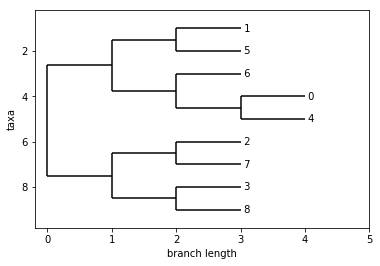

In [12]:
from Bio import Phylo as phy

'''
A lot of BioPython's functions only take file-like objects, 
StringIO just creates a memory buffer that lets a string pretend 
to be a file (technically a string buffer)
'''
from io import StringIO

# create string buffer from Newick string
tree_str = StringIO(str(treedata))
# read tree into a Phylo tree object
tree = phy.read(tree_str, 'newick')

'''
Prints ASCII tree to standard output (probably the console unless 
your setup is weird). If you want it saved to a file either pipe 
the output to a file in terminal or use sys.out (look it up)
'''
phy.draw_ascii(tree, column_width=30)

# if you're too cool for ASCII art (or just born after 1995), Phylo can also draw trees in matplotlib
phy.draw(tree)

To add noise, we added random point mutations in a larger dataset.

In [13]:
seq2 = ['CAGCCGCACACAGATCCTGAG',
       'CAGCTGCACGCAGATCCTGAG',
       'CGGCTGCACGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGGCTGCACGTCGATCCTGAG',
       'CGGCTGCACGTGGATCCTGAG',
       'CAGCTGCATGTGGACCCTGAG', 
       'CAGCTGCATGTGGACCCAGAG', 
       'CGGCTCCATGTGGACCCAGAT'
       'CAGCTGCACGCAGATTTCAAG',
       'CGGCTGCACGCAGATTTCGAG',
       'CAGCTGCACGTGGATTTCGAG',
       'CGGCTGCACGAGGATCCTGAG'
       'CAGCTGCACGCAGATCCTCAG',
       'CGCCTGCACGCAGATCCTGAG',
       'CAGCTGCACGTGGATCCTGAG',
       'CGCCTGCACGTGGATCCAGAG']

In [14]:
dist_mat2 = calc_dist_mat(seq2, DNA_sim)

In [15]:
for row in dist_mat:
    print(['%.1f' % i for i in row])
  
print("\nWhich is the closest sequence pair in the sequence data?")

print(joinPair(dist_mat))
tree2, JoinOrder = njTree(dist_mat2)

['0.0', '0.1']
['0.1', '0.0']

Which is the closest sequence pair in the sequence data?
[0, 1]


In [16]:
treedata2 = tree2
print(treedata2)

((1, ((6, (8, 11)), (13, (7, 10)))), ((0, 5), ((3, (4, 12)), (2, (9, 14)))))


      ____ 1
     |
     |         ____ 6
  ___|     ___|
 |   |    |   |     ____ 8
 |   |    |   |____|
 |   |____|        |____ 11
 |        |
 |        |    ____ 13
 |        |___|
_|            |     ____ 7
 |            |____|
 |                 |____ 10
 |
 |         ___ 0
 |    ____|
 |   |    |___ 5
 |   |
 |___|         ____ 3
     |     ___|
     |    |   |     ____ 4
     |    |   |____|
     |____|        |____ 12
          |
          |    ____ 2
          |___|
              |     ____ 9
              |____|
                   |____ 14



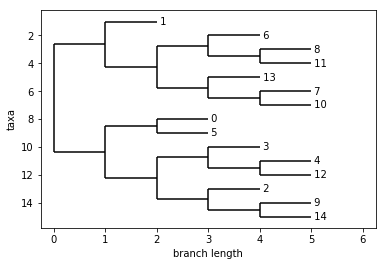

In [17]:
# create string buffer from Newick string
tree_str = StringIO(str(treedata2))
# read tree into a Phylo tree object
tree = phy.read(tree_str, 'newick')

'''
Prints ASCII tree to standard output (probably the console unless 
your setup is weird). If you want it saved to a file either pipe 
the output to a file in terminal or use sys.out (look it up)
'''
phy.draw_ascii(tree, column_width=30)

# if you're too cool for ASCII art (or just born after 1995), Phylo can also draw trees in matplotlib
phy.draw(tree)